# Optimal advertising

## Ad display

In this example we solve a simple optimal advertising problem in CVXPY.
We have $m$ advertisers/ads, $i=1, \ldots, m$, and $n$ time slots, $t=1, \ldots, n$.
$T_t$ is the total traffic in time slot $t$.
$D_{it} \geq 0$ is the number of ad $i$ displayed in period $t$.

Our constraints are that $\sum_i D_{it} \leq T_t$ and that we satisfy our contracts for minimum total displays: $\sum_t D_{it} \geq c_i$.
Our goal is to choose $D_{it}$.

## Clicks and revenue

$C_{it}$ is the number of clicks on ad $i$ in period $t$.
Our click model is $C_{it} = P_{it}D_{it}$, where $P_{it} \in [0,1]$ is the fraction of displays of ad $i$ in time $t$ that translate into clicks.

We are paid $R_i>0$ per click for ad $i$, up to a budget $B_i$.
Our total ad revenue is thus

$$
S_i = \min \left\{ R_i \sum_t C_{it}, B_i\right\},
$$

a concave function of $D$.

## Ad optimization
We choose the displays to maximize revenue, i.e., we solve the optimization problem

$$
\begin{array}{ll} \mbox{maximize} & \sum_i S_i \\
\mbox{subject to} & D \geq 0, \quad D^T{\bf 1} \leq T, \quad
D {\bf 1} \geq c
\end{array}
$$

where the optimization variable is $D\in {\bf R}^{m \times n}$ and $T \in {\bf R}^n$, $c \in {\bf R}^m$, $R \in {\bf R}^m$, $B \in {\bf R}^m$, and $P \in {\bf R}^{m \times n}$ are problem data.

## Example

In the following code we generate and solve an ad optimization problem with 24 hourly periods and 5 ads (A-E).

In [1]:
# Generate data for optimal advertising problem.
import numpy as np

np.random.seed(1)
m = 5
n = 24
SCALE = 10000
B = np.random.lognormal(mean=8, size=(m, 1)) + 10000
B = 1000 * np.round(B / 1000)

P_ad = np.random.uniform(size=(m, 1))
P_time = np.random.uniform(size=(1, n))
P = P_ad.dot(P_time)

T = np.sin(np.linspace(-2 * np.pi / 2, 2 * np.pi - 2 * np.pi / 2, n)) * SCALE
T += -np.min(T) + SCALE

c = np.random.uniform(size=(m,))
c *= 0.6 * T.sum() / c.sum()
c = 1000 * np.round(c / 1000)
R = np.array([np.random.lognormal(c.min() / c[i]) for i in range(m)])
# print(P)


In [2]:
# Form and solve the optimal advertising problem.
import cvxpy as cp

D = cp.Variable((m, n))
Si = [cp.minimum(R[i] * P[i, :] @ D[i, :].T, B[i]) for i in range(m)]
# Si = [R[i] * P[i, :] @ D[i, :].T for i in range(m)]
prob = cp.Problem(
    cp.Maximize(cp.sum(Si)), [D >= 0, D.T @ np.ones(m) <= T, D @ np.ones(n) >= c]
)
# [D >= 0, D.T @ np.ones(m) <= T, D @ np.ones(n) >= c]
prob.solve()
print(cp.installed_solvers())

['CLARABEL', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


We plot the total traffic $T$ below.

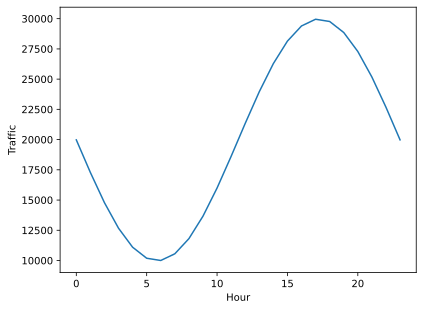

In [3]:
# Plot traffic.
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
plt.plot(T)
plt.xlabel("Hour")
plt.ylabel("Traffic")
plt.show()

We plot the conversion fractions $P$ below.

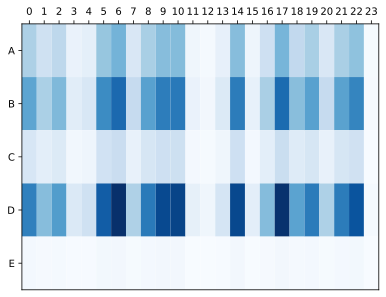

In [4]:
# Plot P.
column_labels = range(0, 24)
row_labels = list("ABCDE")
fig, ax = plt.subplots()
data = D.value
heatmap = ax.pcolor(P, cmap=plt.cm.Blues)
# print(P)
# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(P.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(P.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

We plot the optimal displays $D$ below.

[ 61000.   80103.9 148560.8  23103.  166672.7]
42943.026230359384
[np.float64(176.6), array([12000.]), np.float64(12000.0), array([11000.]), np.float64(7766.4)]


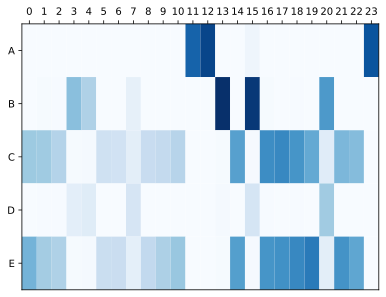

In [5]:
# Plot optimal D.
import matplotlib.pyplot as plt

column_labels = range(0, 24)
row_labels = list("ABCDE")
fig, ax = plt.subplots()
data = D.value

# print(data)
d_opt = np.reshape(data, (m,n))
print(np.round(np.sum(d_opt, axis=1),1))
print(prob.value)
sumclist = []
for i in range(m): # ad
    sumc = min(R[i] * P[i, :].dot(data[i, :].T), B[i])
    sumclist.append(np.round(sumc, 1))
print(sumclist)
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()